# Lifted Transforms and High-Level Optimizers

In the previous tutorial, we learned about the functional API with explicit state management using graph operations. While powerful, that approach requires manual state handling. This tutorial introduces **lifted transforms** - a higher-level API that automatically manages states while preserving JAX's functional programming benefits.

## Learning Objectives

By the end of this tutorial, you will:
- Understand the difference between functional API and lifted transforms
- Use BrainTools optimizers for automatic state management
- Leverage `brainstate.transform` for state-aware JAX transformations
- Build cleaner training loops with less boilerplate code
- Apply the lifted API to the same polynomial regression problem

## Setup and Imports

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import brainstate
import braintools

# Set random seed for reproducibility
np.random.seed(42)

## The Same Problem: Polynomial Regression

We'll use the same dataset as the previous tutorial to highlight the differences in approach:

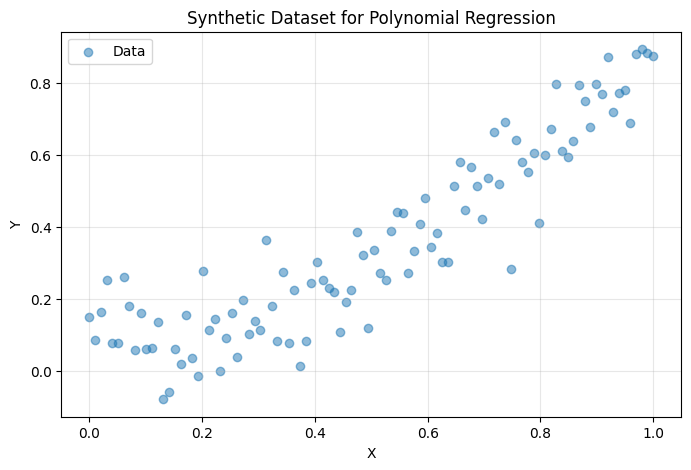

In [2]:
# Generate synthetic data: y = 0.8 * x^2 + 0.1 + noise
X = np.linspace(0, 1, 100)[:, None]
Y = 0.8 * X ** 2 + 0.1 + np.random.normal(0, 0.1, size=X.shape)

def dataset(batch_size):
    """Generator that yields random batches from the dataset."""
    while True:
        idx = np.random.choice(len(X), size=batch_size)
        yield X[idx], Y[idx]

# Visualize the data
plt.figure(figsize=(8, 5))
plt.scatter(X, Y, alpha=0.5, label='Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synthetic Dataset for Polynomial Regression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Building the Model with Lifted Transforms

### Step 1: Define the Model Components

The model definition is similar, but we'll use it differently:

In [3]:
class Linear(brainstate.nn.Module):
    """A simple linear layer: y = x @ w + b"""
    
    def __init__(self, din: int, dout: int):
        super().__init__()
        self.w = brainstate.ParamState(brainstate.random.rand(din, dout))
        self.b = brainstate.ParamState(jnp.zeros((dout,)))
    
    def __call__(self, x):
        return x @ self.w.value + self.b.value


class Count(brainstate.State):
    """Custom state type for tracking function calls."""
    pass


class MLP(brainstate.nn.Module):
    """Multi-layer perceptron with call counting.
    
    Note: Now inherits from nn.Module instead of graph.Node.
    This enables automatic state management.
    """
    
    def __init__(self, din, dhidden, dout):
        super().__init__()  # Important: call parent __init__
        
        self.count = Count(jnp.array(0))
        self.linear1 = Linear(din, dhidden)
        self.linear2 = Linear(dhidden, dout)
    
    def __call__(self, x):
        self.count.value += 1
        x = self.linear1(x)
        x = jax.nn.relu(x)
        x = self.linear2(x)
        return x

### Step 2: Create Model and Optimizer

Now we create the model and use a **BrainTools optimizer** that automatically manages parameter states:

In [4]:
# Create the model
model = MLP(din=1, dhidden=32, dout=1)

# Create optimizer and register trainable weights
optimizer = braintools.optim.SGD(lr=1e-3)
optimizer.register_trainable_weights(model.states(brainstate.ParamState))

print("Model created:")
print(model)
print("\nOptimizer registered with parameters:")
print(jax.tree.map(jnp.shape, optimizer.param_states.to_pytree()))

Model created:
MLP(
  count=Count(
    value=ShapedArray(int32[], weak_type=True)
  ),
  linear1=Linear(
    w=ParamState(
      value=ShapedArray(float32[1,32])
    ),
    b=ParamState(
      value=ShapedArray(float32[32])
    )
  ),
  linear2=Linear(
    w=ParamState(
      value=ShapedArray(float32[32,1])
    ),
    b=ParamState(
      value=ShapedArray(float32[1])
    )
  )
)

Optimizer registered with parameters:
{('linear1', 'b'): (), ('linear1', 'w'): (), ('linear2', 'b'): (), ('linear2', 'w'): ()}


**Key Differences from Functional API:**

1. **No Manual State Splitting**: We don't need to call `treefy_split` - the model and optimizer manage states internally
2. **Optimizer Handles Parameters**: The optimizer automatically tracks and updates parameters
3. **Simpler Code**: Less boilerplate, more readable

## Training with Lifted Transforms

### Understanding Lifted Transforms

**Lifted transforms** automatically handle state management:
- `brainstate.transform.jit`: JIT compilation with automatic state threading
- `brainstate.transform.grad`: Gradients with automatic state differentiation
- States are implicitly updated during function execution

### Step 1: Define Training Step

In [5]:
@brainstate.transform.jit
def train_step(batch):
    """Perform one training step.
    
    Notice how much simpler this is compared to the functional API!
    No need to pass/return states explicitly.
    """
    x, y = batch
    
    def loss_fn():
        # Simply call the model - states are managed automatically
        return jnp.mean((y - model(x)) ** 2)
    
    # Compute gradients
    # The grad transform knows which states to differentiate
    grads = brainstate.transform.grad(
        loss_fn, 
        optimizer.param_states.to_pytree()
    )()
    
    # Update parameters using the optimizer
    optimizer.update(grads)

**Compare with Functional API:**

Functional API (previous tutorial):
```python
def train_step(params, counts, batch):
    x, y = batch
    def loss_fn(params):
        model = brainstate.graph.treefy_merge(graphdef, params, counts)
        y_pred = model(x)
        new_counts = brainstate.graph.treefy_states(model, Count)
        loss = jnp.mean((y - y_pred) ** 2)
        return loss, new_counts
    grad, counts = jax.grad(loss_fn, has_aux=True)(params)
    params = jax.tree.map(lambda w, g: w - 0.1 * g, params, grad)
    return params, counts
```

Lifted API (this tutorial):
```python
def train_step(batch):
    x, y = batch
    def loss_fn():
        return jnp.mean((y - model(x)) ** 2)
    grads = brainstate.transform.grad(loss_fn, optimizer.param_states.to_pytree())()
    optimizer.update(grads)
```

**Much cleaner!**

### Step 2: Define Evaluation Step

In [6]:
@brainstate.transform.jit
def eval_step(batch):
    """Evaluate the model on a batch."""
    x, y = batch
    y_pred = model(x)
    loss = jnp.mean((y - y_pred) ** 2)
    return {'loss': loss}

### Step 3: Run Training

In [7]:
# Training parameters
total_steps = 10_000

# Training loop - notice how clean this is!
print("Training the model...\n")
for step, batch in enumerate(dataset(32)):
    # Simply call train_step - no state management needed!
    train_step(batch)
    
    # Log progress every 1000 steps
    if step % 1000 == 0:
        logs = eval_step((X, Y))
        print(f"Step: {step:5d}, Loss: {logs['loss']:.6f}")
    
    # Stop after total_steps
    if step >= total_steps - 1:
        break

print("\nTraining complete!")

Training the model...

Step:     0, Loss: 17.077118
Step:  1000, Loss: 0.050319
Step:  2000, Loss: 0.018055
Step:  3000, Loss: 0.010365
Step:  4000, Loss: 0.008487
Step:  5000, Loss: 0.007985
Step:  6000, Loss: 0.007841
Step:  7000, Loss: 0.007793
Step:  8000, Loss: 0.007769
Step:  9000, Loss: 0.007754

Training complete!


**Compare Training Loops:**

Functional API:
```python
for step, batch in enumerate(dataset(32)):
    params_, counts_ = train_step(params_, counts_, batch)  # Manual state threading
    if step % 1000 == 0:
        logs = eval_step(params_, counts_, (X, Y))  # Pass states explicitly
```

Lifted API:
```python
for step, batch in enumerate(dataset(32)):
    train_step(batch)  # States handled automatically
    if step % 1000 == 0:
        logs = eval_step((X, Y))  # No state arguments needed
```

## Analyzing Results

In [8]:
# The model already contains the trained parameters!
# No need to merge states like in functional API

print(f"Total model calls during training: {model.count.value}")

# Make predictions
y_pred = model(X)

print(f"Final predictions shape: {y_pred.shape}")

Total model calls during training: 10010
Final predictions shape: (100, 1)


### Visualize Predictions

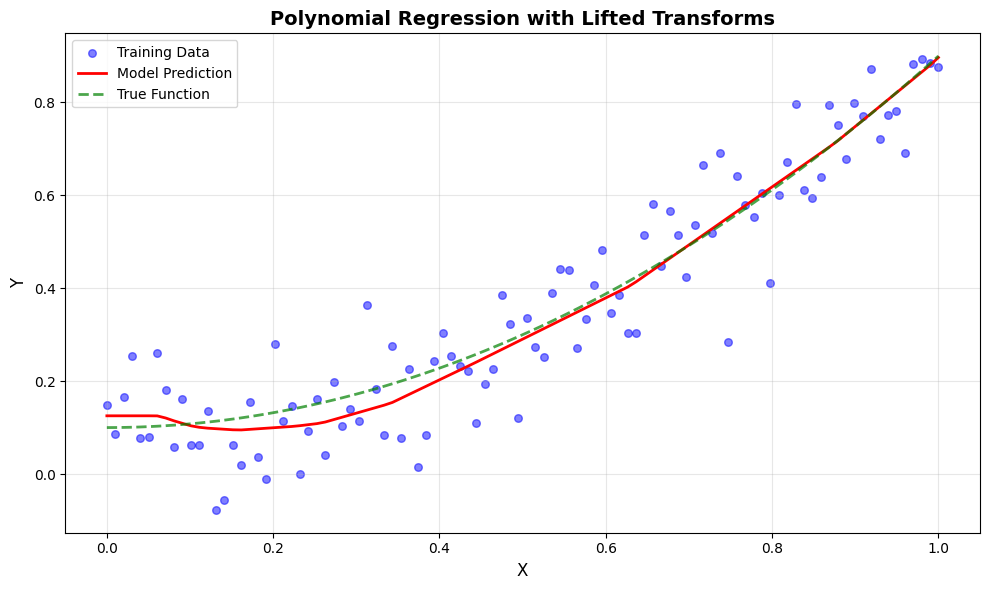

In [9]:
plt.figure(figsize=(10, 6))

# Plot data points
plt.scatter(X, Y, color='blue', alpha=0.5, label='Training Data', s=30)

# Plot predictions
plt.plot(X, y_pred, color='red', linewidth=2, label='Model Prediction')

# Plot true function
X_true = np.linspace(0, 1, 100)[:, None]
Y_true = 0.8 * X_true ** 2 + 0.1
plt.plot(X_true, Y_true, color='green', linewidth=2, 
         linestyle='--', label='True Function', alpha=0.7)

plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Polynomial Regression with Lifted Transforms', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Advanced: Using Different Optimizers

BrainTools provides many optimizers. Let's try Adam optimizer with learning rate scheduling:

In [10]:
# Create a new model
brainstate.random.seed(0)
model_adam = MLP(din=1, dhidden=32, dout=1)

# Create Adam optimizer with exponential decay learning rate
lr_schedule = braintools.optim.ExponentialDecayLR(
    1e-2,           # Initial learning rate
    decay_steps=100,   # Decay every 100 steps
    decay_rate=0.99    # Multiply by 0.99 each decay
)

optimizer_adam = braintools.optim.Adam(lr=lr_schedule)
optimizer_adam.register_trainable_weights(model_adam.states(brainstate.ParamState))

print("Adam optimizer created with learning rate scheduling!")

Adam optimizer created with learning rate scheduling!


In [11]:
# Define training step with the new optimizer
@brainstate.transform.jit
def train_step_adam(batch):
    x, y = batch
    
    def loss_fn():
        return jnp.mean((y - model_adam(x)) ** 2)
    
    grads = brainstate.transform.grad(
        loss_fn, 
        optimizer_adam.param_states.to_pytree()
    )()
    
    optimizer_adam.update(grads)

@brainstate.transform.jit
def eval_step_adam(batch):
    x, y = batch
    y_pred = model_adam(x)
    loss = jnp.mean((y - y_pred) ** 2)
    return {'loss': loss}

In [12]:
# Training with Adam
total_steps = 5_000

print("Training with Adam optimizer...\n")
for step, batch in enumerate(dataset(32)):
    train_step_adam(batch)
    
    if step % 500 == 0:
        logs = eval_step_adam((X, Y))
        current_lr = optimizer_adam.current_lr
        print(f"Step: {step:5d}, Loss: {logs['loss']:.6f}, LR: {current_lr:.6f}")
    
    if step >= total_steps - 1:
        break

print("\nTraining complete!")

Training with Adam optimizer...

Step:     0, Loss: 5.806739, LR: 0.010000
Step:   500, Loss: 0.007895, LR: 0.010000
Step:  1000, Loss: 0.007700, LR: 0.010000
Step:  1500, Loss: 0.007669, LR: 0.010000
Step:  2000, Loss: 0.007656, LR: 0.010000
Step:  2500, Loss: 0.007796, LR: 0.010000
Step:  3000, Loss: 0.007845, LR: 0.010000
Step:  3500, Loss: 0.007663, LR: 0.010000
Step:  4000, Loss: 0.007980, LR: 0.010000
Step:  4500, Loss: 0.007653, LR: 0.010000

Training complete!


## Comparison: Functional API vs Lifted Transforms

| Aspect | Functional API | Lifted Transforms |
|--------|----------------|-------------------|
| **State Management** | Manual (explicit split/merge) | Automatic (implicit) |
| **Code Complexity** | Higher (more boilerplate) | Lower (cleaner code) |
| **Control** | Full control over states | Managed by framework |
| **Learning Curve** | Steeper (need to understand graph ops) | Gentler (similar to PyTorch) |
| **Use Cases** | Custom algorithms, research | Standard training, production |
| **Performance** | Same (both compile to XLA) | Same (both compile to XLA) |
| **Debugging** | Easier to trace states | Harder (implicit state flow) |
| **Flexibility** | Maximum | High (sufficient for most cases) |

### When to Use Each?

**Use Functional API when:**
- Implementing novel optimization algorithms
- Need fine-grained control over state updates
- Debugging complex state interactions
- Research requiring custom gradient computations

**Use Lifted Transforms when:**
- Standard training workflows
- Production deployments
- Rapid prototyping
- When code readability is priority

## Key Concepts Summary

### Lifted Transforms

1. **Automatic State Management**:
   - States are implicitly threaded through computations
   - No need for manual split/merge operations
   - Cleaner, more readable code

2. **BrainTools Optimizers**:
   - Handle parameter registration and updates
   - Support learning rate scheduling
   - Implement various algorithms (SGD, Adam, AdamW, etc.)

3. **BrainState Transforms**:
   - `brainstate.transform.jit`: JIT compilation with state handling
   - `brainstate.transform.grad`: Gradients with automatic state differentiation
   - `brainstate.transform.for_loop`: Efficient loops over sequences

### Best Practices

1. **Start with Lifted API**: Begin with lifted transforms for most projects
2. **Use BrainTools Optimizers**: They handle state management for you
3. **Drop to Functional API when needed**: For advanced control
4. **Profile before optimizing**: Both APIs have same performance

## Exercises

Try these exercises to deepen your understanding:

1. **Experiment with Optimizers**:
   - Try different optimizers (AdamW, RMSprop)
   - Compare convergence speeds
   - Visualize learning curves

2. **Add Regularization**:
   - Implement L2 regularization in the loss function
   - Add dropout layers to the MLP
   - Compare generalization performance

3. **Learning Rate Scheduling**:
   - Implement cosine annealing schedule
   - Try step decay
   - Plot learning rate vs. step

4. **Gradient Clipping**:
   - Add gradient clipping to prevent exploding gradients
   - Monitor gradient norms during training

## Next Steps

Now that you understand both functional and lifted APIs, you can:

1. **Build Complex Models**: Apply these concepts to CNNs, RNNs, and Transformers
2. **Explore Advanced Training**: Learn about mixed precision, gradient accumulation
3. **Dive into Brain Models**: Use these techniques for spiking neural networks
4. **Checkpointing and Deployment**: Save and load trained models

## References

- [BrainState Transform API](https://brainstate.readthedocs.io/en/latest/apis/transform.html)
- [BrainTools Optimizers](https://braintools.readthedocs.io/en/latest/apis/optim.html)
- [JAX Documentation](https://jax.readthedocs.io/)